# Zasady budowania modeli deep learning

## Dlaczego Julia?

W trakcie kursu pracować będziemy w języku [Julia](https://julialang.org/). Dlaczego?

- Język skryptowy (jak Python  czy R)
- Szybkość  (jak C)
- Silny  system [typów](https://upload.wikimedia.org/wikipedia/commons/d/d9/Julia-number-type-hierarchy.svg) 
- Wbudowane  zrównoleglanie  obliczeń
- Łatwość  integracji  integracji (Python, R, C, …) 


### Literatura 

Przydatne linki:
- [Kursy Julia Academy](https://juliaacademy.com/)
- [Podręcznik Boyda i Vandenberghe](http://vmls-book.stanford.edu/)
- [Julia Express](https://github.com/bkamins/The-Julia-Express)
- [wykłady Quantitative Economics Sargenta i Stachurskiego](https://lectures.quantecon.org/jl/)
- [Julia dla Data Science](http://ucidatascienceinitiative.github.io/IntroToJulia/)
- [Think Julia](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html)
- [materiały dostępne na stronie języka](https://julialang.org/learning/)

### Biblioteki

####  1. DataFrames.jl

Biblioteka [<tt>DataFrames</tt>](https://juliadata.github.io/DataFrames.jl/stable/man/getting_started.html) jest narzędziem pozwalającym na efektywną i wygodną pracę ze zbiorami danych. Jest implementacja znanych z <tt>R</tt> ramek danych, oferując wszystkie znane z <tt>R</tt> narzędzia, zaimplementowane w wyraźnie efektywniejszy obliczeniowo sposób. Warto zapoznać się ze szczegółowym [wprowadzeniem do <tt>DataFrames</tt> ](https://github.com/bkamins/Julia-DataFrames-Tutorial).

#### 2. Plots.jl

[Plots]() to podstawowa bibliotka do tworzenia wykresów w Julii. Jedną z jej głównych zalet jest to, że pozwala na wykorzystanie wielu [backendów](http://docs.juliaplots.org/latest/backends/). Warto zapoznać się z [dokumenacją](http://docs.juliaplots.org/latest/) tej biblioteki.

# Przykład motywacyjny

Zacznijmy od prostego przykładu. Dla australijskich danych dotyczących wniosków o karty kredytowe (dostepnych [tutaj](http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat)) zbudujmy model orkreślający prawdopodobieństwo decyzji o odmowie wydania karty kredytowej. Zacznijmy od odpowiedniedgo przygotowania danych:

In [1]:
using DelimitedFiles
using PyPlot
using Statistics
using StatsBase
using DataFrames

In [2]:
isfile("australian.dat") ||
 download("http://archive.ics.uci.edu/ml/machine-learning-databases/
    statlog/australian/australian.dat")
rawdata = readdlm("australian.dat");

In [55]:
df = DataFrames.DataFrame(rawdata)
rename!(df,:x15 => :class)
df[!,:x4] = [x == 1 ? 1.0 : 0.0 for x in df[!,:x4]]
df[!,:x12] = [x == 1 ? 1.0 : 0.0 for x in df[!,:x12]]
df[!,:x14] = log.(df[!,:x14])
first(df,5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,22.08,11.46,0.0,4.0,4.0,1.585,0.0,0.0
2,0.0,22.67,7.0,0.0,8.0,4.0,0.165,0.0,0.0
3,0.0,29.58,1.75,1.0,4.0,4.0,1.25,0.0,0.0
4,0.0,21.67,11.5,1.0,5.0,3.0,0.0,1.0,1.0
5,1.0,20.17,8.17,0.0,6.0,4.0,1.96,1.0,1.0


In [56]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,x1,0.678261,0.0,1.0,1.0,0,Float64
2,x2,31.5682,13.75,28.625,80.25,0,Float64
3,x3,4.75872,0.0,2.75,28.0,0,Float64
4,x4,0.236232,0.0,0.0,1.0,0,Float64
5,x5,7.37246,1.0,8.0,14.0,0,Float64
6,x6,4.69275,1.0,4.0,9.0,0,Float64
7,x7,2.22341,0.0,1.0,28.5,0,Float64
8,x8,0.523188,0.0,1.0,1.0,0,Float64
9,x9,0.427536,0.0,0.0,1.0,0,Float64


In [57]:
countmap(df[!, :class])

Dict{Float64,Int64} with 2 entries:
  0.0 => 383
  1.0 => 307

In [58]:
train_ratio = 0.7

0.7

In [59]:
train_set = df[1:floor(Int,size(df,1)*train_ratio),:];
test_set = df[floor(Int,size(df,1)*train_ratio + 1):end,:];

In [61]:
X_train = Matrix(train_set[:,1:end-1])';
X_test = Matrix(test_set[:,1:end-1])';
y_train = train_set[!, :class];
y_test = test_set[!, :class];

Znormalizujmy zmienne:

In [64]:
function scale(X)

    μ = mean(X, dims=2)
    σ = std(X, dims=2)

    X_norm = (X .- μ) ./ σ

    return (X_norm, μ, σ);
end

function scale(X, μ, σ)
    X_norm = (X .- μ) ./ σ
    return X_norm;
end

scale (generic function with 2 methods)

In [65]:
X_train, μ, σ = scale(X_train);

In [66]:
X_test = scale(X_test, μ, σ);

I zdefiniujmy funkcję szacującą regresję logistyczną, którą chcemy wyliczyć:

In [74]:
β = rand(1,size(X_train,1) + 1);

In [76]:
Predict(β, x) = 1 ./ (1 .+ exp.(-β[1:end-1]' * x .- β[end]))

Predict (generic function with 1 method)

In [77]:
Predict(β,X_train)

1×482 Array{Float64,2}:
 0.525591  0.0224711  0.135534  0.850191  …  0.562108  0.990577  0.287712

Jako funkcję straty wykorzystamy binarną entropię krzyżową (<b> binary cross-entropy </b>, <b>log-loss</b>). Jej wzór to:

$$ H_p(q) = - \sum_{i=1}^N {y_i log(p(y_i)) + (1 - y_i) log(p(1 -y_i))}$$

In [78]:
L(ŷ, y) = (-y') * log.(ŷ') - (1 .- y') * log.(1 .- ŷ')

L (generic function with 1 method)

Do rozwiązania zadanego problemu wykorzystamy [metodę gradientu prostego](https://pl.wikipedia.org/wiki/Metoda_gradientu_prostego). Zdefiniujmy funkcję, która wyznacza gradient:

In [79]:
function simple_∇(β, X, y)
    J = L(Predict(β, X),y)[1] 
    ∇ = Float64[]
    for i = 1:length(β)
        b = β[i]
        β′ = β .+ (LinearIndices(β) .== i) * b * √eps()
        β′′ = β .- (LinearIndices(β) .== i) * b * √eps()
        Δf = (L(Predict(β′,X),y)[1] - L(Predict(β′′,X),y)[1]) / (2*b*√eps())
        push!(∇,Δf)
    end
    return J, ∇
end

simple_∇ (generic function with 1 method)

In [80]:
simple_∇(β,X_train,y_train)

(310.99143274806204, [42.59349369717351, -12.77394007224877, -8.37117072759901, 43.281044600977346, -29.109321073605205, -2.3863478664732614, -7.307291417401367, -63.81519355295201, -2.1209134902211844, -14.78266862890722, 33.37526851525864, 47.07844316783632, 60.563240480930205, 0.9226767260033218, 64.07559363552699])

In [89]:
function solve!(β, X, y;
            η = 0.001, ϵ = 10^-10, maxit = 50_000)
    iter = 1
    Js = Float64[]
    J, ∇ = simple_∇(β, X, y)
    push!(Js,J)
    while true
        β₀ = β
        β -= η * ∇'
        J, ∇ = simple_∇(β, X, y)
        push!(Js,J)
        stop = maximum(abs.(β .- β₀))
        stop < ϵ && break
        iter += 1
        iter > maxit && break
    end
    return Js
end

solve! (generic function with 1 method)

In [90]:
Js = solve!(β,X_train, y_train);

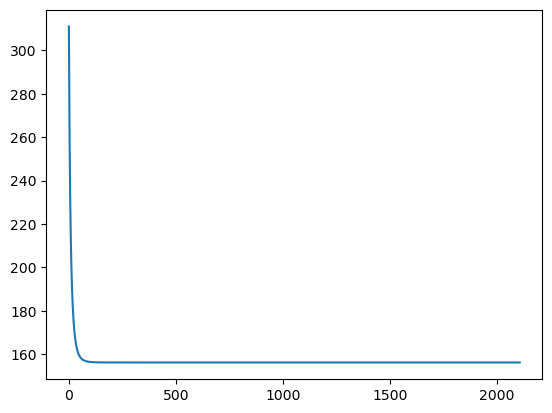

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004ACC4520>

In [96]:
plot(Js)

In [92]:
accuracy(β, X, y, T = 0.5) = sum((Predict(β, X)' .≥ T ).== y)/length(y)

accuracy (generic function with 2 methods)

In [93]:
accuracy(β, X_test, y_test)

0.7211538461538461

# Modele deep learning

Gdy dane są już gotowe kolejnym krokiem jest odpowiednie zdefiniowanie modelu na którym będziemy pracować. Wykorzystamy do tego bibliotekę [flux.jl](http://fluxml.ai/):

- [Flux](http://fluxml.ai/) jest biblioteką Julii przeznaczoną do tworzenia modeli uczenia maszynowego.
- Jest w całości oparta na Julii, przez co trywialne jest jej modyfikowanie i dostosowywanie do swoich potrzeb. 
- Możliwe jest przy tym wykorzystanie wewnątrz modeli składni, funkcji i makr Julii.
- Przy czym tworzenie całkiem złożonych standardowych modeli jest intuicyjne i szybkie, zazwyczaj zajmują one jedynie kilka linijek.

### Warstwy sieci neuronowej

Jak już wspomnieliśmy wcześniej Flux jest wpełni modyfikowalny i możemy samodzielnie zdefiniować warstwy takiej sieci, korzystając np. z sigmoidalnej funkcją aktywacji:

In [1]:
@time using Flux

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278


183.173743 seconds (36.30 M allocations: 2.081 GiB, 0.67% gc time)


In [4]:
W = rand(4, 8)
b = rand(4)
layer₁(x) = 1.0 ./ (1.0.+exp.(-W*x - b))

layer₁ (generic function with 1 method)

In [5]:
W

4×8 Array{Float64,2}:
 0.35236   0.0328713  0.905054   0.130202  …  0.660327  0.304524  0.241281
 0.584042  0.643298   0.0702007  0.82034      0.16933   0.484917  0.402627
 0.762929  0.894717   0.0571691  0.397298     0.843338  0.151259  0.963783
 0.156017  0.552638   0.508521   0.858061     0.929617  0.180455  0.943868

In [6]:
x = rand(8)
layer₁(x)

4-element Array{Float64,1}:
 0.7322913679380594
 0.9602791846359574
 0.9354597442882386
 0.9461501555289937

Przy czym w przypaku najpowszechniejszych funkcji nie musimy ich samodzielnie deklarować. Flux dostarcza  najpopularniejsze funkcje aktywacji i podstawowe typy [warstw modelu](https://fluxml.ai/Flux.jl/stable/models/layers/#Basic-Layers-1):

In [7]:
layer₂(x) = σ.(W * x .+ b)
layer₂(x)

4-element Array{Float64,1}:
 0.7322913679380594
 0.9602791846359574
 0.9354597442882386
 0.9461501555289937

In [8]:
layer₃ = Dense(8,4,σ)
layer₃(x)

4-element Array{Float64,1}:
 0.5841164776652511
 0.5198569551951393
 0.2685663241213857
 0.48115983952928654

Możemy zdefiniować też własne warstwy jako obiekty:

In [9]:
struct Poly
    W
    V
    b
end

Poly(in::Integer, out::Integer) =
  Poly((randn(out, in)),randn(out, in), (randn(out)))

# Overload call, so the object can be used as a function
(m::Poly)(x) = m.W * x.^2 + m.V*x .+ m.b

a = Poly(10, 5)

a(rand(10)) # => 5-element vector

5-element Array{Float64,1}:
 -7.041686705707139
  2.7964720692979173
 -1.29419391026765
 -0.16581644821010133
 -0.708918544248989

Znów, samo zdefioniowanie warstwy jako obiektu nie wystarczy do wykorzystania wszystkich funkcji Fluxa. Gdy chcemy wykorzystać wbudowane we Fluxa narzędzia do wyznaczania gradientu czy też [liczyć model na GPU](https://fluxml.ai/Flux.jl/stable/gpu/)  musimy jeszcze skorzystać z makra <tt>@functor </tt>:

In [10]:
Flux.@functor  Poly

In [11]:
gpu(a);

Chcąc zbudować model z więcej niż jedną warstwą musimy go odpowiednio zdefiniować:

In [12]:
Layer₁ = Dense(28^2, 32, relu)
Layer₂ = Dense(32, 10)
Layer₃ = softmax

softmax (generic function with 2 methods)

Funkcja <tt>Chain</tt> pozwala łączyć w łancuchy dowolne funkcje w Julii:

In [13]:
chain = Chain(x -> x^2, x-> -x)
m₁ = Chain(Layer₁ , Layer₂, Layer₃) 

Chain(Dense(784, 32, relu), Dense(32, 10), softmax)

Możemy zdefiniować model także jako złożenie funkcji:

In [14]:
m₂(x) = Layer₃(Layer₂(Layer₁(x)))

m₂ (generic function with 1 method)

In [15]:
m₃(x) = Layer₁ ∘ Layer₂ ∘ Layer₃  

m₃ (generic function with 1 method)

Albo jako potok:

In [16]:
m₄(x) = Layer₁(x) |> Layer₂  |> Layer₃ 

m₄ (generic function with 1 method)

### Funkcje straty i regularyzacja

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, rozdział 7](http://www.deeplearningbook.org/contents/regularization.html)

Tak jak mówiliśmy na poprzednim wykładzie nie mamy możliwości bezpośredniej optymalizacji wag $\theta$ w modelu. Do procesu uczenia musimy wykorzystać funkcję straty $J(\theta)$.

Funkcję straty możemy zdefiniować samodzielnie:

In [ ]:
model = Dense(5,2)
x, y = rand(5), rand(2);
loss(ŷ, y) = sum((ŷ.- y).^2)/ length(y)
loss(model(x), y) 

albo wykorzystać [jedną z zaimplementowanych we Fluxie:](https://github.com/FluxML/Flux.jl/blob/8f73dc6e148eedd11463571a0a8215fd87e7e05b/src/layers/stateless.jl):

In [ ]:
Flux.mse(model(x),y)

Jednak samo zdefiniowanie funkcji straty nie wystarczy. Dobry model uczenia maszynowego musi mieć możliwie jak najniższy <b>błąd generalizacji</b>:

[![](https://cdn-images-1.medium.com/max/1600/1*1woqrqfRwmS1xXYHKPMUDw.png)](https://buzzrobot.com/bias-and-variance-11d8e1fee627)


Niestety sieci neuronowe mają tendencję do przeuczania się i w przypadku ich używania konieczne jest wykorzystanie odpowiedniej metody <b>regularyzacji</b>. Dzięki temu możliwe będzie zaproponowanie modelu, który będzie umiał efektywnie aproksymować dane inne niż trenujące.

Do najczęściej wykorzystywanych metod regularyzacji należą:


<b>nakładanie kar na parametry</b>:

Jeden z najczęściej wykorzystywanych sposobów regularyzacji. Polega on na nałożeniu unormowanej kary na parametry funkcji straty: 
     
$\tilde{J}(\theta) = J(\theta) + \alpha\Omega(\theta)$

Najczęściej spotykamy się z postaciami:
- $\Omega(\theta) = ||w||_1 = \sum_i{|w_i|}$     (<i>LASSO</i>,<i>regularyzacja $L_1$</i>)
- $\Omega(\theta) = ||w||_2^2 = \sum_i{w_i^2}$ (<i>regularyzacja Tichonowa</i>, <i>regresja grzbietowa</i>,<i>regularyzacja $L_2$</i>)

Ich implementacja wyglądałaby [następująco](https://fluxml.ai/Flux.jl/stable/models/regularisation/):

In [ ]:
using LinearAlgebra

In [ ]:
L₁(θ) = sum(abs, θ) 
L₂(θ) = sum(abs2, θ) 

In [ ]:
J(x,y,W) = loss(model(x),y) + L₁(W)

In [ ]:
J(x,y,W)

<b>Bagging (bootstrap aggregating)</b>:

Polega on na losowaniu ze zwracaniem $k$ próbek z wejściowego zbioru danych i szacowaniu na nich $k$  modeli, a następnie uśrednianiu ich rezultatów.

<b>Dropout</b>:

Polega na tworzeniu nowych modeli poprzez usuwanie neuronów z warstw ukrytych z prawdopodobieństwem $p$ w każdej iteracji uczenia. Niech wektor $\mu = [1,1,0,1,1,1,\dots,0,1]$ oznacza neurony wykorzystane do uczenia modelu w danej iteracji $i$. W takim wypadku procedura uczenia sprowadza się do minimalizacji wartości wyrażenia $E_\mu[J(\theta,\mu)]$ dla każdej kolejnej iteracji. Dzięki temu otrzymujemy nieobciążony estymator gradientu bez konieczności generowania i uczenia $k$ modeli tak jak w przypadku baggingu.

Dropout implementuje się we Fluxie jako [warstwę modelu](https://fluxml.ai/Flux.jl/stable/models/layers/#Normalisation-and-Regularisation-1): 

In [ ]:
model = Chain(Dense(28^2, 32, relu),
    Dropout(0.1),
Dense(32, 10),
BatchNorm(64, relu),
softmax)

### Optymalizacja sieci

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, rozdział 8](http://www.deeplearningbook.org/contents/optimization.html)

Dobór odpowiedniego algorytmu optymalizacyjnego jest jednym z najważniejszych kroków w trakcie przygotowywania sieci neuronowej. Specyfika procesu ich uczenia powoduje, że proces optymalizacji jest podatny na wiele potencjalnych problemów, między innymi:
- złe uwarunkowanie macierzy.
- występowanie lokalnych minimów, punktów siodłowych, etc.
- zjawiska zanikającego i eksplodującego gradientu

Z tego powodu istnieje wiele różnych algorytmów, które próbują przeciwdziałać wymienionym powyżej problemom. To który z nich powinien być zastosowany zależy tak naprawdę od specyfiki rozpatrywanego przypadku. Do najpopularnieszych należą:
- SGD [(Robbins & Munro 1951)](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586)
- SGD z pędem (momentum) [(Polyak, 1964)](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=zvmmf&paperid=7713&option_lang=eng)
- SGD z pędem Nesterova ([Nesterov, 1983](http://www.cis.pku.edu.cn/faculty/vision/zlin/1983-A%20Method%20of%20Solving%20a%20Convex%20Programming%20Problem%20with%20Convergence%20Rate%20O%28k%5E%28-2%29%29_Nesterov.pdf), [2005](https://www.math.ucdavis.edu/~sqma/MAT258A_Files/Nesterov-2005.pdf))
- AdaGrad (Adaptive Gradient Algorithm) [(Duchi et. al. 2011)](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
- ADAM (Adaptive Moment Estimation) [(Kingma & Ba, 2015)](https://arxiv.org/abs/1412.6980)



Flux umożliwia [wyznaczanie gradientu dowolnej funkcji](https://fluxml.ai/Flux.jl/stable/models/basics/) i przekazanie go do modelu:

In [ ]:
f(x) = 3x^2 + 2x + 1

# df/dx = 6x + 2
df(x) = gradient(f, x)[1]

df(2) # 14.0 

# d²f/dx² = 6
d²f(x) = gradient(df, x)[1]

d²f(2) # 6.0 

Dotyczy to także dowolnych funkcji (nie tylko tych wyrażonych za pomocą metamatycznej formuły): 

In [22]:
function pow(x, n)
    r = 1
    for i = 1:n
        r *= x
    end
    return r
end

pow (generic function with 1 method)

In [23]:
pow(2,4)

16

In [ ]:
gradient(x -> pow(x, 3), 5)

In [ ]:
pow2(x, n) = n <= 0 ? 1 : x*pow2(x, n-1)

In [ ]:
gradient(x -> pow2(x, 3), 5)

Dzieje się tak dzięki odpowiednio skonstruowanemu mechanizmowi różniczkowania, który efektywnie wykorzystuje charakterystykę języka.  Biblioteka [<tt>Zygote.jl</tt>](https://fluxml.ai/Zygote.jl/latest/) służy do automatycznego różniczkowania w Julii. Wprowadzenie do sposobu jej działania dostępne jest [tutaj](https://github.com/MikeInnes/diff-zoo) i [tutaj](https://arxiv.org/pdf/1810.07951.pdf).

### Automatyczne różniczkowanie

Kluczowym elementem poprawnie działającej biblioteki do uczenia maszynowego jest odpowiedni algorytm wyznaczający gradient funkcji. Jak wiemy z poprzednich zajęć naiwne wyznaczanie gradientu za pomocą definicji pochodnej:
$$\frac{df}{dx} = \lim_{h \to 0}\frac{f(x_0 +h) - f(x_0)}{h}$$
nie jest efektywne numerycznie. W jaki sposób możemy wyznaczać wartości pochodnych?

Okazuje się, że każda, nawet najbardziej skomplikowana funkcja, którą liczymy jest niczym innym niż złożeniem podstawowych operacji arytmetycznych i kilku bazowych funkcji (sin,cos,log,etc.).  Znając podstawowe reguły wyliczania tych pochodnych możemy w efektywny sposób wyznaczyć wartość pochodnej korzystając z reguły łańcuchowej:

$$
\frac{dy}{dx} = \frac{dy_1}{dx}*\frac{dy_2}{dy_1}*\dots*\frac{dy_{n-1}}{dy_{n-2}}*\frac{dy}{dy_{n-1}}
$$

Różniczkowanie można wykonać na dwa sposoby:
#
- <b>do przodu</b> zaczynamy ze znaną wartością $\frac{dy_0}{dx} = \frac{dx}{dx} = 1$. Następnie wyznaczamy wartość dla kolejnej instrukcji  $\frac{dy_1}{dx} = \frac{d_1}{dx} = 1$ i następnie:$\frac{dy_{i+1}}{dy_i}$, aż otrzymamy pełny łańcuch.

- <b>do tyłu</b> zaczynamy ze znaną wartością  $\frac{dy}{dy_n} = \frac{dy}{dy} = 1$. Następnie wyznaczamy wartości: $\frac{dy}{dy_n}$, $\frac{dy}{dy_{n-1}}$, ... $\frac{dy}{dy_1}$, $\frac{dy}{dx}$.  

## Zygote.jl

De facto całe działanie biblioteki <tt>Zygote</tt> opiera się na dwóch kluczowych elementach: makrze <tt>@adjoint</tt> i funkcji <tt>pullback</tt>. 

<tt>pullback</tt> zwraca dwa wyniki, wartość oryginalnej funkcji $y = f(x)$ i wyrażenie $\overline{y}  \frac{dy}{dx}$, gdzie $\overline{y} = \frac{dl}{dy}$ $l$ jest parametrem, który musimy zdefiniować dla dowolnej funkcji $l$.  

In [17]:
using Zygote

In [18]:
y, back = Zygote.pullback(sin, π);

In [19]:
y

1.2246467991473532e-16

In [20]:
back(0.5)

(-0.5,)

W szczególności funkcja <tt>gradient</tt> zakłada, że  $l = y = f(x)$ i $\overline{y} = \frac{dy}{dl} = 1$:

In [21]:
gradient(sin,π) == back(1)

true

Makro <tt>@adjoint</tt> pozwala nam w dowolny sposób modyfikować działanie mechanizmu wyznaczającego pochodne:

In [ ]:
using Zygote: @adjoint

In [ ]:
minus(a,b) = a - b

In [ ]:
gradient(minus,2,3)

In [ ]:
minus2(a,b) = a - b

In [ ]:
@adjoint minus2(a,b) = minus2(a,b), c̄ -> (nothing, -b^2)

In [ ]:
gradient(minus2,2,3)

 Flux ponadto posiada zdefiniowane [podstawowe algorytmy optymalizacyjne:](https://fluxml.ai/Flux.jl/stable/training/optimisers/)

In [ ]:
opt = ADAM(0.0001)

### Uczenie modelu

Flux jest zdolny do kontrolowania całej procedury uczenia, nie musimy robić tego samodzielnie. Służy do tego funkcja <tt>train!</tt>:

In [ ]:
Flux.train!(objective, data, opt)

Warto jednak zaznaczyć, że pozwala ona na uczenie jedynie przez pojedynczą epokę. Aby móc kontynuować proces uczenia dalej musimy w odpowiedni sposób przystować dane z których korzystamy:

In [ ]:
using Base.Iterators: repeated
dataset = repeated((x, y), 200)

albo skorzystać z makra <tt>@epochs</tt>:

In [ ]:
Flux.@epochs 2 println("hello")

Pozwala ona też na definiowanie wywołań, które pozwolą nam kontrolować przebieg uczenia.

In [ ]:
evalcb = () -> @show(loss(tX, tY))

## Przykład

In [ ]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated

Zacznijmy od podstaw, wczytajmy i opracujmy zbiór danych na którym będziemy pracowali:

In [ ]:

# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) 

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) 

Zdefiniujmy model:

In [ ]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) 

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) 
tY = onehotbatch(MNIST.labels(:test), 0:9) 

accuracy(tX, tY)

Otrzymane wyniki możemy zapisywać korzystając z biblioteki <tt>BSON</tt>:

In [ ]:
using BSON

In [ ]:
BSON.@save "MNIST.bson" m

i oczywiście wczytywać:

In [ ]:
BSON.@load "MNIST.bson" m

### Strojenie hiperparametrów

Sieć neuronowa potrafi zoptymalizować jedynie wagi $\theta$ funkcji liniowych wykorzystanych do budowy modelu. Pozostałe parametry (funkcje aktywacji, metoda regularyzacji, stopa uczenia, etc.) muszą być przyjęte z góry. Dobrać je można na kilka różnych sposobów:
- wzorując się na literaturze
- zgadując parametry
- tworząc model [zdolny do nauczenia się optymalnej metody uczenia](https://github.com/FluxML/model-zoo/tree/master/other/meta-learning)
- przeszukując odpowiednio przestrzeń hiperparametrów

In [ ]:
using PyPlot

#### Krata równomierna

In [ ]:
p = hcat(sort(repeat(1:32,32)),repeat(1:32,32))
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

#### Liczby (pseudo)losowe

In [ ]:
p = rand(1024,2)
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

#### Sekwencje Sobola

In [ ]:
using Sobol
s = SobolSeq(2)
p = hcat([next!(s) for i = 1:1000]...)'
subplot(111, aspect="equal")
plot(p[:,1], p[:,2], "r.")

## Dodatkowa praca domowa

1. Dokonaj strojenia hiperparametrów sieci omawianej na wykładzie. Sprobuj znaleźć taką, która zapewnia wyższą trafność predykcji.
2. W trakcie zajęć mówiliśmy o liczbach dualnych, czyli liczbach postaci $z = a + \epsilon b$, gdzie $a,b \in \mathbb{R}$ a  $\epsilon^2 = 0$. Dla dowolnego wielomanu  postaci $f(x) = a_0 + a_1x + a_2x^2 + \dots + a_nx^n$ wartość takiego wielomianu dla liczby dualnej $z$ jest równa: $f(z) = f(a) + bf'(a)\epsilon$. Pokaż, że tak jest naprawdę. 